Ye ab tak ka code:

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


def process_image(frame):
    
    def cal_undistort(img):
        # Reads mtx and dist matrices, peforms image distortion correction and returns the undistorted image

        import pickle

        # Read in the saved matrices
        my_dist_pickle = pickle.load( open( "output_files/calib_pickle_files/dist_pickle.p", "rb" ) )
        mtx = my_dist_pickle["mtx"]
        dist = my_dist_pickle["dist"]

        img_size = (img.shape[1], img.shape[0])    

        undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
        #undistorted_img =  cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)   #Use if you use cv2 to import image. ax.imshow() needs RGB image
        return undistorted_img

    
    def yellow_threshold(img, sxbinary):
        # Convert to HLS color space and separate the S channel
        # Note: img is the undistorted image
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        h_channel = hls[:,:,0]
        # Threshold color channel
        s_thresh_min = 100
        s_thresh_max = 255
        
        #for 360 degree, my value for yellow ranged between 35 and 50. So uska half kar diya
        h_thresh_min = 10    
        h_thresh_max = 25

        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

        h_binary = np.zeros_like(h_channel)
        h_binary[(h_channel >= h_thresh_min) & (h_channel <= h_thresh_max)] = 1

        # Combine the two binary thresholds
        yellow_binary = np.zeros_like(s_binary)
        yellow_binary[(((s_binary == 1) | (sxbinary == 1) ) & (h_binary ==1))] = 1
        return yellow_binary
    
    def xgrad_binary(img, thresh_min=30, thresh_max=100):
        # Grayscale image
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Sobel x
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        # Threshold x gradient
        #thresh_min = 30    #Already given above
        #thresh_max = 100

        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
        return sxbinary
    
    def white_threshold(img, sxbinary, lower_white_thresh = 170):
        r_channel = img[:,:,0]
        g_channel = img[:,:,1]
        b_channel = img[:,:,2]
        # Threshold color channel
        r_thresh_min = lower_white_thresh
        r_thresh_max = 255
        r_binary = np.zeros_like(r_channel)
        r_binary[(r_channel >= r_thresh_min) & (r_channel <= r_thresh_max)] = 1
        
        g_thresh_min = lower_white_thresh
        g_thresh_max = 255
        g_binary = np.zeros_like(g_channel)
        g_binary[(g_channel >= g_thresh_min) & (g_channel <= g_thresh_max)] = 1

        b_thresh_min = lower_white_thresh
        b_thresh_max = 255
        b_binary = np.zeros_like(b_channel)
        b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1

        white_binary = np.zeros_like(r_channel)
        white_binary[((r_binary ==1) & (g_binary ==1) & (b_binary ==1) & (sxbinary==1))] = 1
        return white_binary
        
    def thresh_img(img):
                       
       
        #sxbinary = xgrad_binary(img, thresh_min=30, thresh_max=100)
        sxbinary = xgrad_binary(img, thresh_min=25, thresh_max=130)
        yellow_binary = yellow_threshold(img, sxbinary)     #(((s) | (sx)) & (h))
        white_binary = white_threshold(img, sxbinary, lower_white_thresh = 150)
        
        # Combine the two binary thresholds
        combined_binary = np.zeros_like(sxbinary)
        combined_binary[((yellow_binary == 1) | (white_binary == 1))] = 1
        
        out_img = np.dstack((combined_binary, combined_binary, combined_binary))*255
        
        return out_img
    
    def perspective_transform(img):
    
        # Define calibration box in source (original) and destination (desired or warped) coordinates

        img_size = (img.shape[1], img.shape[0])
        """Notice the format used for img_size. Yaha bhi ulta hai. x axis aur fir y axis chahiye. 
              Apne format mein rows(y axis) and columns (x axis) hain"""


        # Four source coordinates
        # Order of points: top left, top right, bottom right, bottom left
        
        src = np.array(
            [[435*img.shape[1]/960, 350*img.shape[0]/540],
             [530*img.shape[1]/960, 350*img.shape[0]/540],
             [885*img.shape[1]/960, img.shape[0]],
             [220*img.shape[1]/960, img.shape[0]]], dtype='f')
        

        # Next, we'll define a desired rectangle plane for the warped image.
        # We'll choose 4 points where we want source points to end up 
        # This time we'll choose our points by eyeballing a rectangle

        dst = np.array(
            [[290*img.shape[1]/960, 0],
             [740*img.shape[1]/960, 0],
             [740*img.shape[1]/960, img.shape[0]],
             [290*img.shape[1]/960, img.shape[0]]], dtype='f')


        #Compute the perspective transform, M, given source and destination points:
        M = cv2.getPerspectiveTransform(src, dst)

        #Warp an image using the perspective transform, M; using linear interpolation    
        #Interpolating points is just filling in missing points as it warps an image
        # The input image for this function can be a colored image too
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
              
        return warped, src, dst 

    def rev_perspective_transform(img, src, dst):

        img_size = (img.shape[1], img.shape[0])

        #Compute the perspective transform, M, given source and destination points:
        Minv = cv2.getPerspectiveTransform(dst, src)

        #Warp an image using the perspective transform, M; using linear interpolation    
        #Interpolating points is just filling in missing points as it warps an image
        # The input image for this function can be a colored image too
        un_warped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
              
        return un_warped 

    
    def draw_polygon(img1, img2, src, dst):
        src = src.astype(int)  #Very important step (Pixels cannot be in decimals)
        dst = dst.astype(int)
        cv2.polylines(img1, [src], True, (255,0,0), 3)
        cv2.polylines(img2, [dst], True, (255,0,0), 3)
    
    def histogram_bottom_peaks (warped_img):
        # This will detect the bottom point of our lane lines
        
        # Take a histogram of the bottom half of the image
        bottom_half = warped_img[((2*warped_img.shape[0])//5):,:,0]     # Collecting all pixels in the bottom half
        histogram = np.sum(bottom_half, axis=0)                         # Summing them along y axis (or along columns)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)        # 1D array hai histogram toh uska bas 0th index filled hoga 
        #print(np.shape(histogram))     #OUTPUT:(1280,)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        return leftx_base, rightx_base
    
    def find_lane_pixels(warped_img):
    
        leftx_base, rightx_base = histogram_bottom_peaks(warped_img)
   
        
        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 9
        # Set the width of the windows +/- margin. So width = 2*margin 
        margin = 90
        # Set minimum number of pixels found to recenter window
        minpix = 1000    #I've changed this from 50 as given in lectures
    
        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(warped_img.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = warped_img.nonzero()  #pixel ke coordinates dega 2 seperate arrays mein
        nonzeroy = np.array(nonzero[0])    # Y coordinates milenge 1D array mein. They will we arranged in the order of pixels
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base         #initially set kar diya hai. For loop ke end mein change karenge
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []   # Ismein lane-pixels ke indices collect karenge. 
                              # 'nonzerox' array mein index daalke coordinate mil jaayega
        right_lane_inds = []  

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = warped_img.shape[0] - (window+1)*window_height
            win_y_high = warped_img.shape[0] - window*window_height
            """### TO-DO: Find the four below boundaries of the window ###"""
            win_xleft_low = leftx_current - margin  
            win_xleft_high = leftx_current + margin  
            win_xright_low = rightx_current - margin  
            win_xright_high = rightx_current + margin 
            
            """
            # Create an output image to draw on and visualize the result
            out_img = np.copy(warped_img)
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
            """

            ### TO-DO: Identify the nonzero pixels in x and y within the window ###
            #Iska poora explanation seperate page mein likha hai
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]

            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]


            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on the mean position of the pixels in your current window (re-centre)
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    
        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass
    
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        """return leftx, lefty, rightx, righty, out_img""" #agar rectangles bana rahe ho toh out_image rakhna
        return leftx, lefty, rightx, righty
        

    def fit_polynomial(warped_img, leftx, lefty, rightx, righty, right_history):
    
        #Fit a second order polynomial to each using `np.polyfit` ###
        left_fit = np.polyfit(lefty,leftx,2)
        right_fit = np.polyfit(righty,rightx,2)

        # Generate x and y values for plotting. 
        #NOTE: y is the independent variable. Refer "fit polynomial" notes for explanation
        # We'll plot x as a function of y
        ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
        
        # Eqn of parabola: a(x**2) + bx + c. Where a and b denote the shape of parabola. Shape of parabola will be amost constant inn our case 
        
        
        try:        
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            
            if(right_history == [0,0,0]):
                a2 = (0.6*left_fit[0] + 0.4*right_fit[0])
                b2 = (0.6*left_fit[1] + 0.4*right_fit[1])
                c2 = (warped_img.shape[1] - (left_fit[0]*(warped_img.shape[0]-1)**2 + left_fit[1]*(warped_img.shape[0]-1) + left_fit[2]))*0.1 + 0.9*right_fit[2]

            else:
                a2_new = (0.6*left_fit[0] + 0.4*right_fit[0])
                b2_new = (0.6*left_fit[1] + 0.4*right_fit[1])  
                c2_new = (warped_img.shape[1] - (left_fit[0]*(warped_img.shape[0]-1)**2 + left_fit[1]*(warped_img.shape[0]-1) + left_fit[2]))*0.1 + 0.9*right_fit[2]
                
                a2_old= right_history[0]
                b2_old= right_history[1]       
                c2_old= right_history[2]
                
                a2= a2_new*0.3 + a2_old*0.7
                b2= b2_new*0.3 + b2_old*0.7
                c2= c2_new*0.3 + c2_old*0.7
            
            right_fitx = a2*ploty**2 + b2*ploty + c2
            
            status = True
        
        #try:
        #    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        #    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
                
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty
            status = False

        
        return left_fit, [a2,b2,c2], left_fitx, right_fitx, status
        # out_img here has boxes drawn and the pixels are colored 
    
    def color_pixels_and_curve(out_img, leftx, lefty, rightx, righty, left_fitx, right_fitx):
        ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        
        # Converting the coordinates of our line into integer values as index of the image can't take decimals
        left_fitx_int = left_fitx.astype(np.int32)
        right_fitx_int = right_fitx.astype(np.int32)
        ploty_int = ploty.astype(np.int32)
        
        # Coloring the curve as yellow
        out_img[ploty_int,left_fitx_int] = [255,255,0]
        out_img[ploty_int,right_fitx_int] = [255,255,0]
        
        # To thicken the curve
        out_img[ploty_int,left_fitx_int+1] = [255,255,0]
        out_img[ploty_int,right_fitx_int+1] = [255,255,0]
        out_img[ploty_int,left_fitx_int-1] = [255,255,0]
        out_img[ploty_int,right_fitx_int-1] = [255,255,0]
        out_img[ploty_int,left_fitx_int+2] = [255,255,0]
        out_img[ploty_int,right_fitx_int+2] = [255,255,0]
        out_img[ploty_int,left_fitx_int-2] = [255,255,0]
        out_img[ploty_int,right_fitx_int-2] = [255,255,0]
        
        
        
    def search_around_poly(warped_img, left_fit, right_fit):
        # HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        # The quiz grader expects 100 here, but feel free to tune on your own!
        margin = 100

        # Grab activated pixels
        nonzero = warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ### TO-DO: Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        ### Hint: consider the window areas for the similarly named variables ###
        ### in the previous quiz, but change the windows to our new search area ###
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        return leftx, lefty, rightx, righty

    
    
    undist_img = cal_undistort(frame)
    thresh_img = thresh_img(undist_img)    # Note: This is not a binary iamge. It has been stacked already within the function
    warped_img, src, dst = perspective_transform(thresh_img)

    #draw_polygon(frame, warped_img, src, dst)   #the first image is the original image that you import into the system

    if (lane.count == 0):
        leftx, lefty, rightx, righty = find_lane_pixels(warped_img)     # Find our lane pixels first
        left_fit, right_fit, left_fitx, right_fitx, status = fit_polynomial(warped_img, leftx, lefty, rightx, righty, right_history=[0,0,0])
        
    elif (lane.count > 0):
        left_fit_previous = lane.current_fit[lane.count - 1][0]
        right_fit_previous = lane.current_fit[lane.count - 1][1]
        leftx, lefty, rightx, righty = search_around_poly(warped_img, left_fit_previous, right_fit_previous)
        left_fit, right_fit, left_fitx, right_fitx, status = fit_polynomial(warped_img, leftx, lefty, rightx, righty, right_history=right_fit_previous)
        
    color_pixels_and_curve(warped_img, leftx, lefty, rightx, righty, left_fitx, right_fitx)
    
    lane.count = lane.count+1
    lane.detected = status
    lane.current_fit.append([left_fit, right_fit])
    #lane.current_xfitted.append([left_fitx, right_fitx])
    #lane.allx.append([leftx,rightx])
    #lane.ally.append([lefty, righty])
    #lane.image_output.append(warped_img)
    
    unwarped_img = rev_perspective_transform(warped_img, src, dst)
    
    return unwarped_img
    
    

Let's try classes

3


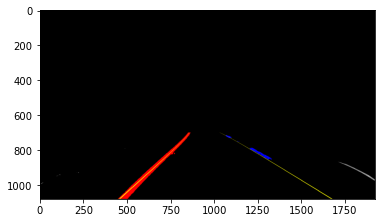

In [4]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        #Let's count the number of consecutive frames
        self.count = 0
        # was the line detected in the last iteration?
        self.detected = False  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        # x values of the curve that we fit intially
        #self.current_xfitted = []
        # x values for detected line pixels
        #self.allx = []  
        # y values for detected line pixels
        #self.ally = []
        #store your image in this
        #self.image_output = []
        
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        
        
lane=Line()


frame1= mpimg.imread("my_test_images/Highway_snaps/image (1).jpg")
frame2= mpimg.imread("my_test_images/Highway_snaps/image (2).jpg")
frame3= mpimg.imread("my_test_images/Highway_snaps/image (3).jpg")


process_image(frame1)
process_image(frame2)
plt.imshow(process_image(frame3))

print(lane.count)

#print(np.shape(lane.image_output))
#plt.imshow(lane.image_output[2])


Videoo test



In [2]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        #Let's count the number of consecutive frames
        self.count = 0
        # was the line detected in the last iteration?
        self.detected = False  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        # x values of the curve that we fit intially
        #self.current_xfitted = []
        # x values for detected line pixels
        #self.allx = []  
        # y values for detected line pixels
        #self.ally = []
        #store your image in this
        #self.image_output = []
        
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')      
        
lane=Line()

project_output = 'output_files/video_clips/project_video.mp4'

clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(25,45)

project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images! 
%time project_clip.write_videofile(project_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_files/video_clips/project_video.mp4.
Moviepy - Writing video output_files/video_clips/project_video.mp4



Moviepy - Done !
Moviepy - video ready output_files/video_clips/project_video.mp4
Wall time: 6min 5s


In [3]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))